**Adding PFF Defense Rankings Feature to model**

Using RF Model

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

In [2]:
pbp = pd.read_csv('../../Data/play-by-play/pbp_exp8.csv')

categorical_cols = ['OffenseTeam', 'DefenseTeam', 'play_type', 'side_of_field','stadium','play_type_nfl','roof','surface_type','home_team', 'away_team','season_type','offense_formation']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    pbp[col] = le.fit_transform(pbp[col].astype(str))
    label_encoders[col] = le  # Save encoders if needed later

Confusion Matrix for fold 1:
[[1227  392]
 [1027  592]]


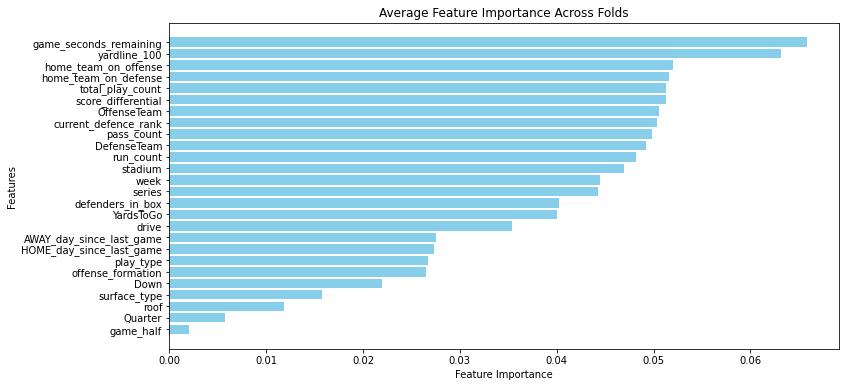

Accuracy scores for each fold: [0.5818406423718344, 0.5617665225447808, 0.5472513897467572, 0.47869054972205066, 0.573810994441013, 0.5429277331686226, 0.5639283508338481, 0.5494132180358245, 0.4654107473749228, 0.5525015441630636, 0.5571340333539222, 0.5327362569487338, 0.5441630636195183, 0.532118591723286, 0.6016059295861643, 0.6300185299567634, 0.4573810994441013, 0.5509573810994441, 0.7001235330450896, 0.5639283508338481, 0.5497220506485485, 0.586781964175417, 0.5509573810994441, 0.5911056207535516, 0.5722668313773934, 0.5123533045089561, 0.560840024706609, 0.531809759110562, 0.6426806670784435, 0.5679431747992588, 0.5460160592958616, 0.5806053119209389, 0.5744286596664607, 0.6003705991352687, 0.5602223594811612, 0.5327362569487338, 0.6290920321185918, 0.5571340333539222, 0.624768375540457, 0.544780728844966, 0.5092649783817171, 0.6201358863495985, 0.5660901791229154, 0.5003088326127239, 0.583384805435454, 0.5333539221741815, 0.5725756639901174, 0.5948116121062385, 0.6260037059913

In [ ]:
X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense',
               'defenders_in_box', 'offense_formation',
               'pass_count', 'run_count', 'current_defence_rank']]


y = pbp['Player-Injured-On-Play']

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
feature_importances = np.zeros(X.shape[1])

accuracy_scores = []
precision_scores = []
feature_importances = np.zeros(X.shape[1])

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train RandomForest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict & Evaluate
    y_pred = rf_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

    # Store feature importances
    feature_importances += rf_model.feature_importances_

    # Get confusion matrix for a specific fold
    if fold == 1: 
        cm = confusion_matrix(y_test_resampled, y_pred)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6), facecolor='white')
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')